In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import albumentations as A
import gc

import torch as tch
from keras.utils import to_categorical
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification ,ConvNextImageProcessor
from transformers import DeiTImageProcessor, DeiTForImageClassificationWithTeacher


from torch.nn.parameter import Parameter
# import torch_xla
# import torch_xla.core.xla_model as xm

device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [2]:
# # Cloud Storage
# from google.cloud import storage
# storage_client = storage.Client(project='drs_classification')

In [3]:
train_df = pd.read_csv('../input/drs-retino/train.csv').sample(frac = 1, random_state = 2728).reset_index(drop = True)

In [4]:
contrast_root = '../input/diabetic-retinopathy-train/contrast/contrast/'
enh_root = '../input/diabetic-retinopathy-train/enhance-001/enhance/'
croped_root = '../input/diabetic-retinopathy-train/croped-002/croped/'

# EDA

<AxesSubplot:xlabel='target', ylabel='Count'>

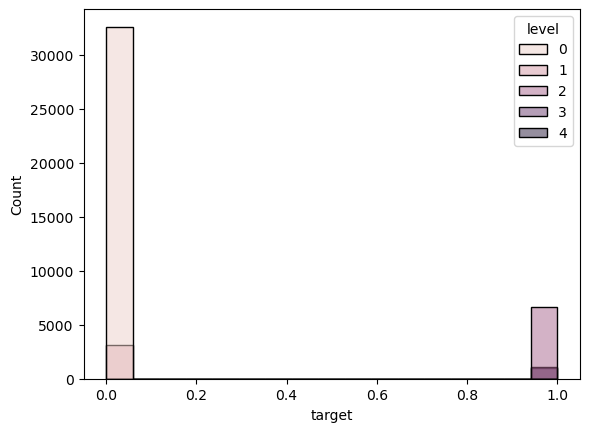

In [5]:
sns.histplot(data = train_df, x = 'target', hue = 'level')

In [6]:
t1 = train_df[train_df['target'] == 1]

<AxesSubplot:xlabel='level', ylabel='Count'>

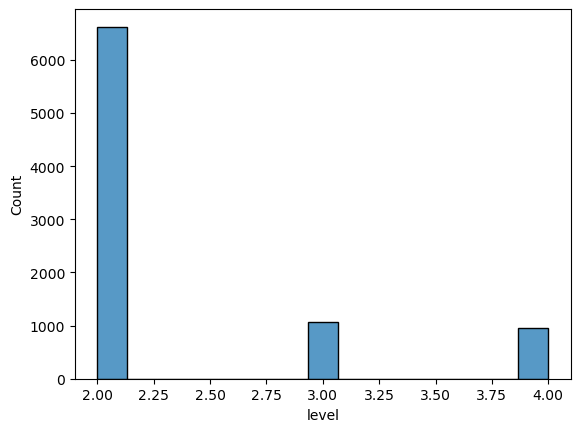

In [7]:
sns.histplot(data = train_df[train_df['target'] == 1], x = 'level')

In [8]:
print('Target count :')
print( f'Target | 0 | = {train_df[train_df.target == 0].shape[0]} samples' )
print( f'Target | 1 | = {train_df[train_df.target == 1].shape[0]} samples' )
print('-------------------------------')

print('Level count :')
print( f'Level | 0 | = {train_df[train_df.level == 0].shape[0]} samples' )
print( f'Level | 1 | = {train_df[train_df.level == 1].shape[0]} samples' )
print( f'Level | 2 | = {train_df[train_df.level == 2].shape[0]} samples' )
print( f'Level | 3 | = {train_df[train_df.level == 3].shape[0]} samples' )
print( f'Level | 4 | = {train_df[train_df.level == 4].shape[0]} samples' )
print('-------------------------------')
print(f'Total sample : {train_df.shape[0]}')

Target count :
Target | 0 | = 35706 samples
Target | 1 | = 8637 samples
-------------------------------
Level count :
Level | 0 | = 32575 samples
Level | 1 | = 3131 samples
Level | 2 | = 6626 samples
Level | 3 | = 1059 samples
Level | 4 | = 952 samples
-------------------------------
Total sample : 44343


In [9]:
fig_size = (12,12)

[529 700 632 184]


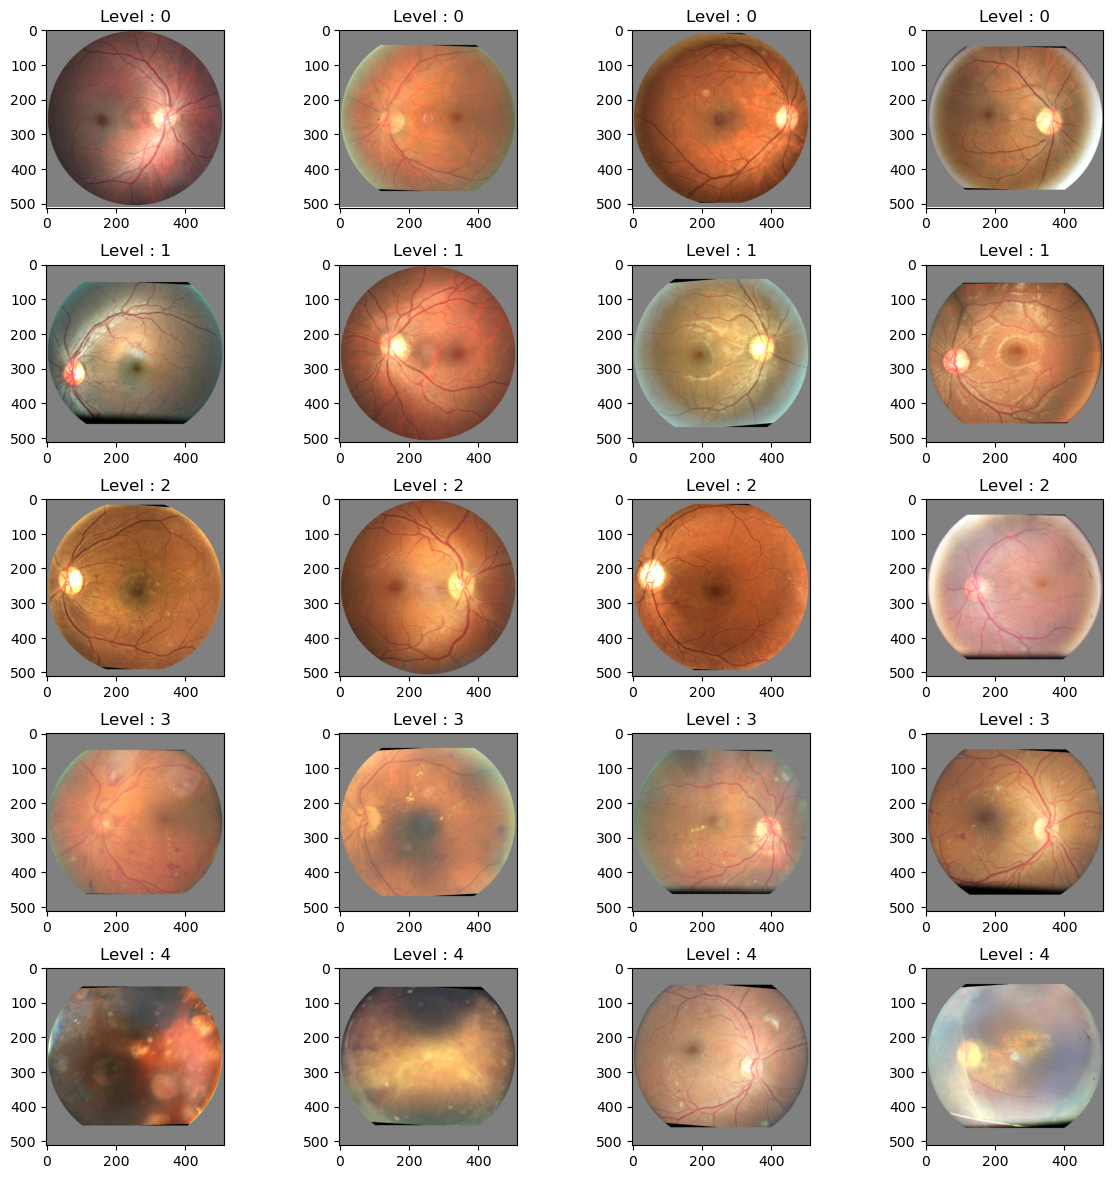

In [10]:
rand_arr = np.random.randint(0,952,4)
print(rand_arr)

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = croped_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

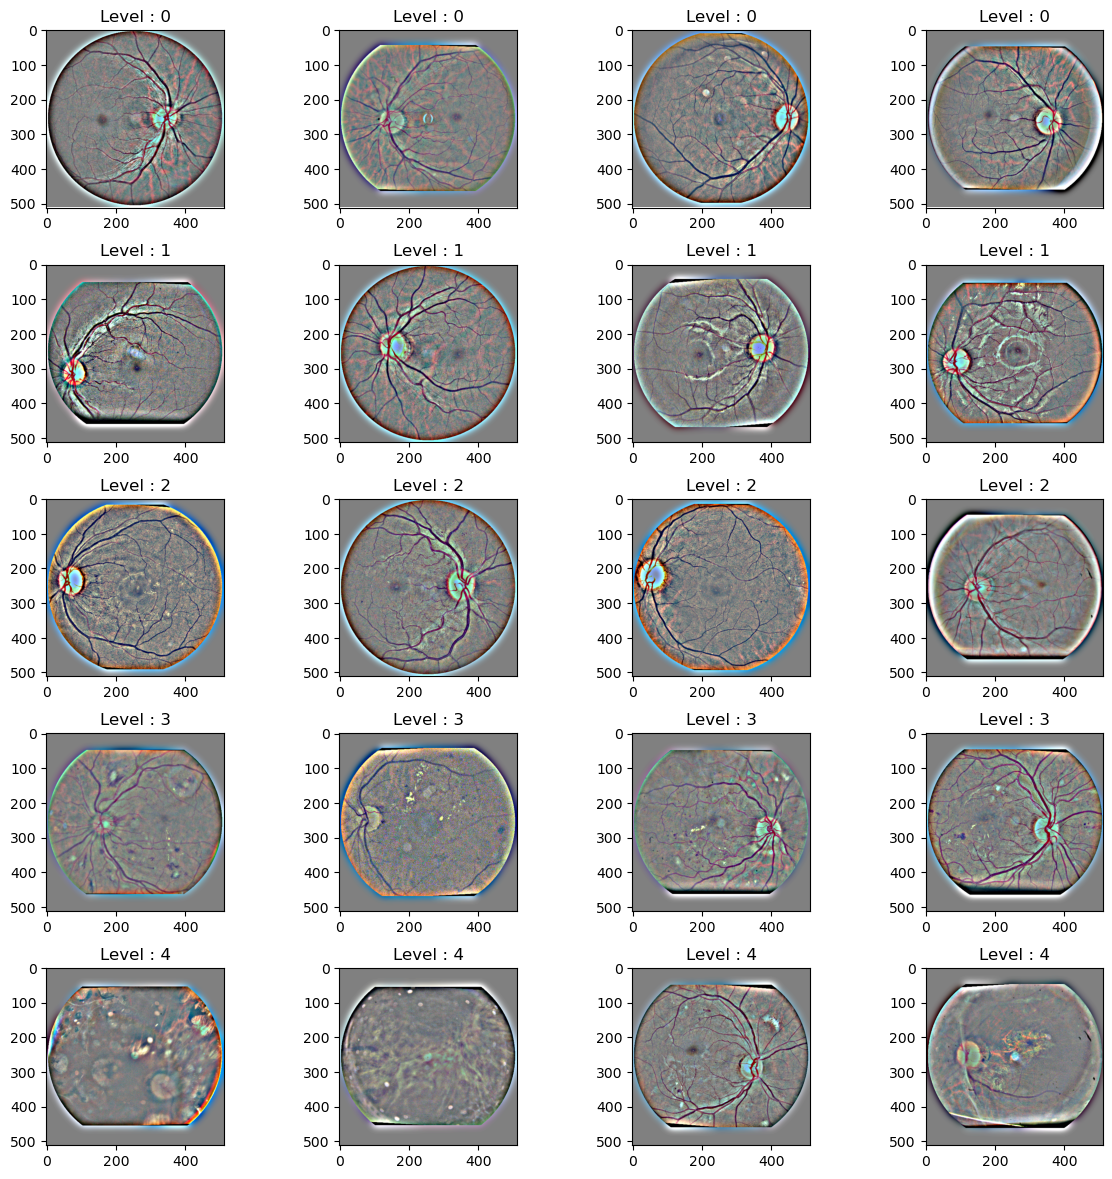

In [11]:

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = contrast_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

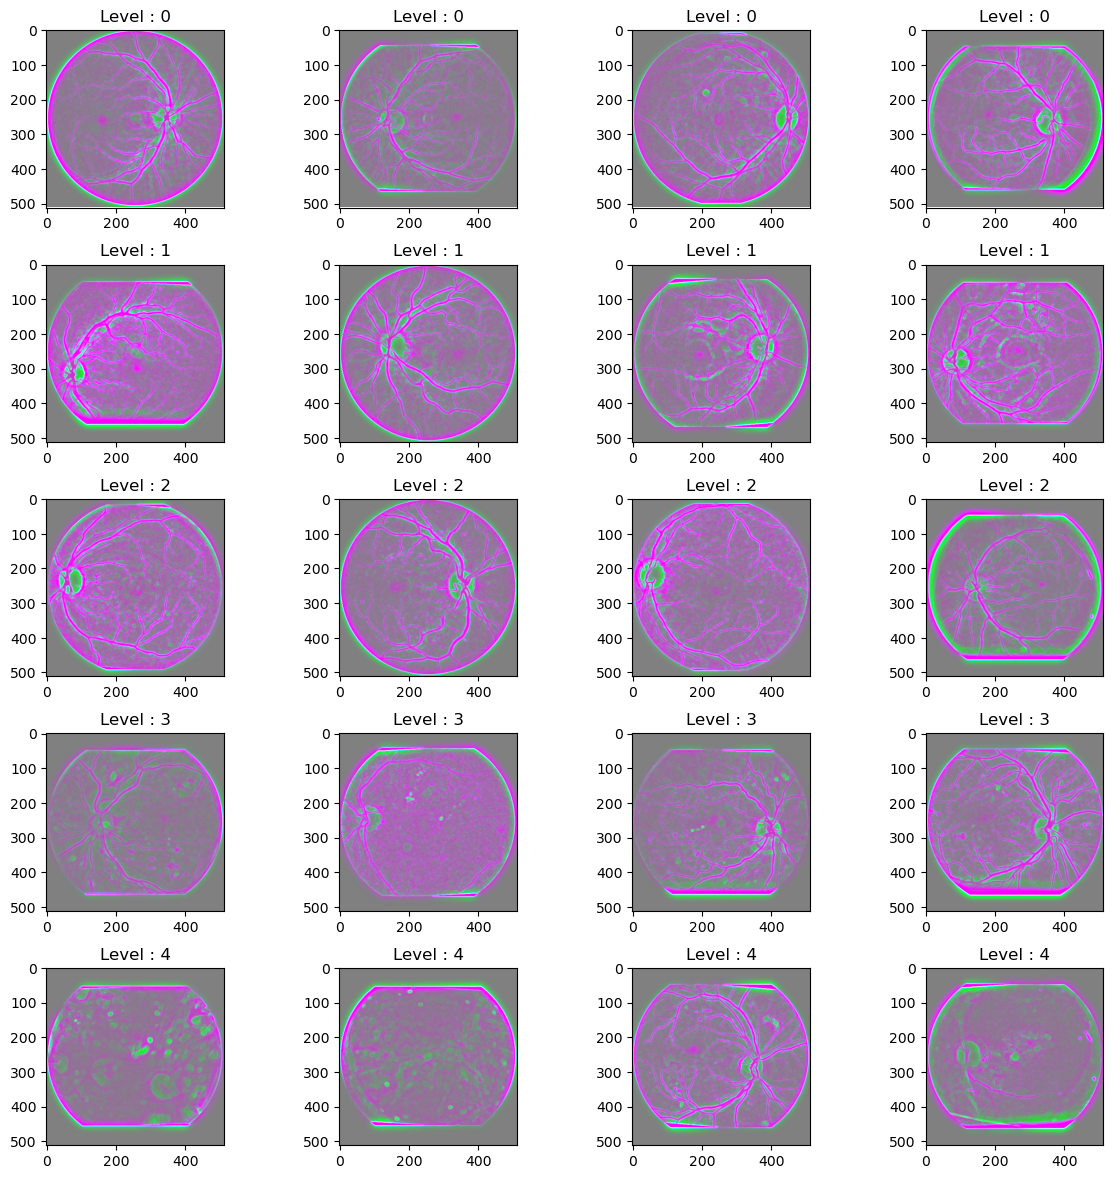

In [12]:
fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = enh_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

In [13]:
train_df

filename  level  target
0      im_80557.png      0       0
1      im_75804.png      0       0
2      im_54097.png      2       1
3      im_55937.png      0       0
4      im_63993.png      0       0
...             ...    ...     ...
44338  im_86503.png      0       0
44339  im_16881.png      0       0
44340  im_44521.png      1       0
44341  im_45835.png      0       0
44342  im_19961.png      0       0

[44343 rows x 3 columns]

# Lion Optimizer

In [14]:
import torch
from torch.optim.optimizer import Optimizer

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1 - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1 - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)

# class

class Lion(Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

    @torch.no_grad()
    def step(
        self,
        closure = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p]

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

# Feed batch on fly ------

In [15]:
class BatchFeeder:
    def __init__(self, df,img_size, batch_size, root, transform = None, one_hot = True, div_255 = False):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.root = root
        self.transform = transform
        self.div_255 = div_255
        self.one_hot = one_hot

        
    def feed(self,ib):
        batchX = []
        batchY = []
        df = self.df[int(ib*self.batch_size):int( (ib*self.batch_size) + self.batch_size )]
        for i in df.iterrows():
            img_path = self.root + i[1][0]
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            img_arr = cv2.resize(img_arr,(self.img_size,self.img_size))
            
            if self.transform:
                img_arr = self.transform( image = img_arr )['image']
                
            if self.div_255:
                img_arr = self.arr_round(self.pic_div_255(img_arr))
            
            if self.one_hot:
                batchY.append(to_categorical(i[1][1],num_classes = 5))
            else:
                batchY.append(i[1][1])
            
            batchX.append(img_arr)
        return tch.from_numpy(np.array(batchX).astype(np.float32)),\
                tch.from_numpy(np.array(batchY))
    
    def pic_div_255(self,img):
        return img / 255
    
    def arr_round(self,img):
        return np.round(img,5)

In [16]:
transform = A.Compose([
#     A.Blur( p = 0.2 ),
    A.Flip( p = 0.2 ),
#    A.RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45,p=0.2),
    A.ShiftScaleRotate(p = 0.2),
#     A.ElasticTransform( p = 0.2),
    A.Transpose(p = 0.2),
#     A.GridDistortion(p = 0.2),
    A.HueSaturationValue(5,5,5,p = 0.2 ),
    A.CLAHE( p = 0.2 )], 
    #A.CoarseDropout( p = 0.2 ),],
    p = 1.0)

In [17]:
train = train_df[: int(train_df.shape[0] * 0.8) ]
test = train_df[int(train_df.shape[0] * 0.8): ]

# Modeling

In [18]:
processor = ViTImageProcessor.from_pretrained('nateraw/vit-age-classifier')
model = ViTForImageClassification.from_pretrained('nateraw/vit-age-classifier')

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
model.classifier = tch.nn.Sequential(
    tch.nn.Linear(768,512),
    tch.nn.ReLU(),
    tch.nn.Linear(512,train_df.level.nunique()),
)

#

# model.classifier = tch.nn.Linear(768,train_df.level.nunique())
model= tch.nn.DataParallel(model)
model = model.to(device)

In [21]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.5 MB/s eta 0:00:00


In [22]:
from torcheval.metrics.functional import multiclass_f1_score

In [23]:
def val_on_batch(model, img_size, batch_size, transform, criterion, size = 0.022):
    df = test[:int(test.shape[0] * size)]
    stepsE = df.shape[0] // batch_size
    print(stepsE)
    val_loss = 0
    val_acc = 0
    f1_val = 0
    for st in range(stepsE):
        model.eval()
        bfd_test = BatchFeeder(df,img_size,batch_size,contrast_root).feed(st)
        x_inp = processor(bfd_test[0],return_tensors="pt")
        y_inp = bfd_test[1].to(device)

        with tch.no_grad():
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1),num_classes=5)
            
        f1_val += f1_.item() / stepsE
        val_loss += loss.item() / stepsE
        val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
    
    return val_loss,val_acc / df.shape[0],f1_val

In [24]:
def train_model(model,img_size,ep,batch_size,criterion,optimizer,scheduler):
    
    stepsT = train.shape[0] // batch_size
    stepsE = test.shape[0] // batch_size
#     Xtrain.to(device)
#     Xtest.to(device)
#     Ytrain.to(device)
#     Ytest.to(device)
    best_val = 0
    for i in range(ep):
        print(f'Ep: {i+1}')
        
        train_loss = 0
        val_loss = 0
        
        train_acc = 0
        val_acc = 0
        
        train_f1 = 0
        val_f1 = 0
        ## Train
        for st in tqdm(range(stepsT)):
            model.train()
            # Prepare the Input
            bfd_train = BatchFeeder(train,img_size,batch_size,contrast_root,transform).feed(st)
            
            x_inp = processor(bfd_train[0], return_tensors="pt")
            y_inp = bfd_train[1].to(device)
            
            optimizer.zero_grad()
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() / stepsT
            train_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            train_f1 += f1_.item() / stepsT
            
            if (st+1) % 20 == 0:
                print('Eval ---------------- Eval')
                ls,acc,f1 = val_on_batch(model, img_size, batch_size, transform, criterion)
                print(f'Loss: {ls:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}')
                tch.save(model,'/kaggle/working/checkpoint.pth')
                
                if acc > best_val:
                    tch.save(model,'/kaggle/working/checkpoint_hof.pth')
                    best_val = acc
            
#             if (train_acc / (batch_size * st)) > best_val:
# #                 print('Best val score saving model...')
#                 tch.save(model,f'checkpoint_hof.pth')
#                 best_val = (train_acc / (batch_size * st))
            
            scheduler.step()
        tch.cuda.empty_cache()
        
        
        ## Test
        for st in tqdm(range(stepsE)):
            model.eval()
            # Prepare the Input
            bfd_test = BatchFeeder(test,img_size,batch_size,contrast_root).feed(st)
            
            x_inp = processor(bfd_test[0],return_tensors="pt")
            y_inp = bfd_test[1].to(device)
            
            with tch.no_grad():
                out = model(**x_inp.to(device))
                loss = criterion(out.logits,y_inp)
            
            f1_ = multiclass_f1_score(out.logits.argmax(1), y_inp.argmax(1))
            val_f1 += f1_.item() / stepsE
            val_loss += loss.item() / stepsE
            val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            
        print(f'Train loss: {train_loss:.4f} | Train acc: {(train_acc / train.shape[0]):.4f}')
        print(f'Val loss: {val_loss:.4f} | Val acc: {(val_acc / test.shape[0]):.4f}')
        print(f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

In [25]:
criterion = tch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = tch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [26]:
train_model(model,224,2,50,criterion,optimizer,scheduler)

Ep: 1


  3%|▎         | 19/709 [00:38<17:48,  1.55s/it]

Eval ---------------- Eval
3
Loss: 0.9868 | Acc: 0.5846 | F1: 0.7600


  6%|▌         | 39/709 [01:16<18:08,  1.62s/it]

Eval ---------------- Eval
3
Loss: 0.8503 | Acc: 0.5846 | F1: 0.7600


  8%|▊         | 59/709 [01:51<16:35,  1.53s/it]

Eval ---------------- Eval
3
Loss: 0.8394 | Acc: 0.5846 | F1: 0.7600


 11%|█         | 79/709 [02:25<15:51,  1.51s/it]

Eval ---------------- Eval
3
Loss: 0.8176 | Acc: 0.5846 | F1: 0.7600


 14%|█▍        | 99/709 [02:59<15:58,  1.57s/it]

Eval ---------------- Eval
3
Loss: 0.8224 | Acc: 0.5846 | F1: 0.7600


 17%|█▋        | 119/709 [03:34<15:32,  1.58s/it]

Eval ---------------- Eval
3
Loss: 0.8171 | Acc: 0.5846 | F1: 0.7600


 20%|█▉        | 139/709 [04:09<14:42,  1.55s/it]

Eval ---------------- Eval
3
Loss: 0.8111 | Acc: 0.5846 | F1: 0.7600


 22%|██▏       | 159/709 [04:44<14:19,  1.56s/it]

Eval ---------------- Eval
3
Loss: 0.8064 | Acc: 0.5846 | F1: 0.7600


 25%|██▌       | 179/709 [05:19<13:45,  1.56s/it]

Eval ---------------- Eval
3
Loss: 0.8028 | Acc: 0.5846 | F1: 0.7600


 28%|██▊       | 199/709 [05:53<13:06,  1.54s/it]

Eval ---------------- Eval
3
Loss: 0.7990 | Acc: 0.5846 | F1: 0.7600


 31%|███       | 219/709 [06:29<13:16,  1.63s/it]

Eval ---------------- Eval
3
Loss: 0.7986 | Acc: 0.5846 | F1: 0.7600


 34%|███▎      | 239/709 [07:04<12:18,  1.57s/it]

Eval ---------------- Eval
3
Loss: 0.7983 | Acc: 0.5846 | F1: 0.7600


 37%|███▋      | 259/709 [07:39<11:50,  1.58s/it]

Eval ---------------- Eval
3
Loss: 0.7979 | Acc: 0.5846 | F1: 0.7600


 39%|███▉      | 279/709 [08:14<11:43,  1.64s/it]

Eval ---------------- Eval
3
Loss: 0.7975 | Acc: 0.5846 | F1: 0.7600


 42%|████▏     | 299/709 [08:49<10:28,  1.53s/it]

Eval ---------------- Eval
3
Loss: 0.7972 | Acc: 0.5846 | F1: 0.7600


 45%|████▍     | 319/709 [09:24<10:15,  1.58s/it]

Eval ---------------- Eval
3
Loss: 0.7972 | Acc: 0.5846 | F1: 0.7600


 48%|████▊     | 339/709 [09:58<09:36,  1.56s/it]

Eval ---------------- Eval
3
Loss: 0.7971 | Acc: 0.5846 | F1: 0.7600


 51%|█████     | 359/709 [10:33<09:19,  1.60s/it]

Eval ---------------- Eval
3
Loss: 0.7971 | Acc: 0.5846 | F1: 0.7600


 53%|█████▎    | 379/709 [11:09<08:51,  1.61s/it]

Eval ---------------- Eval
3
Loss: 0.7971 | Acc: 0.5846 | F1: 0.7600


 56%|█████▋    | 399/709 [11:44<08:01,  1.55s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 59%|█████▉    | 419/709 [12:19<07:46,  1.61s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 62%|██████▏   | 439/709 [12:53<07:00,  1.56s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 65%|██████▍   | 459/709 [13:28<06:19,  1.52s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 68%|██████▊   | 479/709 [14:02<05:55,  1.54s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 70%|███████   | 499/709 [14:37<05:19,  1.52s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 73%|███████▎  | 519/709 [15:11<04:57,  1.57s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 76%|███████▌  | 539/709 [15:45<04:19,  1.53s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 79%|███████▉  | 559/709 [16:19<03:52,  1.55s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 82%|████████▏ | 579/709 [16:53<03:14,  1.50s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 84%|████████▍ | 599/709 [17:27<02:47,  1.52s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 87%|████████▋ | 619/709 [18:01<02:17,  1.52s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 90%|█████████ | 639/709 [18:35<01:49,  1.57s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 93%|█████████▎| 659/709 [19:10<01:18,  1.57s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 96%|█████████▌| 679/709 [19:44<00:46,  1.56s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 99%|█████████▊| 699/709 [20:19<00:15,  1.55s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


100%|██████████| 177/177 [04:23<00:00,  1.49s/it]


Train loss: 0.8894 | Train acc: 0.7315
Val loss: 0.8706 | Val acc: 0.7360
Train F1: 0.7320 | Val F1: 0.7376
Ep: 2


  3%|▎         | 19/709 [00:26<16:23,  1.43s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


  6%|▌         | 39/709 [00:58<15:40,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


  8%|▊         | 59/709 [01:30<15:11,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 11%|█         | 79/709 [02:01<14:37,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 14%|█▍        | 99/709 [02:33<14:14,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 17%|█▋        | 119/709 [03:05<13:37,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 20%|█▉        | 139/709 [03:36<13:15,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 22%|██▏       | 159/709 [04:08<12:46,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 25%|██▌       | 179/709 [04:39<12:55,  1.46s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 28%|██▊       | 199/709 [05:12<13:27,  1.58s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 31%|███       | 219/709 [05:45<12:11,  1.49s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 34%|███▎      | 239/709 [06:17<11:22,  1.45s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 37%|███▋      | 259/709 [06:48<10:09,  1.35s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 39%|███▉      | 279/709 [07:20<10:02,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 42%|████▏     | 299/709 [07:51<09:24,  1.38s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 45%|████▍     | 319/709 [08:23<09:11,  1.42s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 48%|████▊     | 339/709 [08:55<08:39,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 51%|█████     | 359/709 [09:26<08:05,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 53%|█████▎    | 379/709 [09:57<07:41,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 56%|█████▋    | 399/709 [10:29<07:07,  1.38s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 59%|█████▉    | 419/709 [11:00<06:33,  1.36s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 62%|██████▏   | 439/709 [11:31<06:08,  1.36s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 65%|██████▍   | 459/709 [12:02<05:38,  1.35s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 68%|██████▊   | 479/709 [12:33<05:23,  1.41s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 70%|███████   | 499/709 [13:05<04:58,  1.42s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 73%|███████▎  | 519/709 [13:36<04:22,  1.38s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 76%|███████▌  | 539/709 [14:07<03:54,  1.38s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 79%|███████▉  | 559/709 [14:39<03:26,  1.38s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 82%|████████▏ | 579/709 [15:10<03:03,  1.41s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 84%|████████▍ | 599/709 [15:41<02:34,  1.40s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 87%|████████▋ | 619/709 [16:12<02:06,  1.41s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 90%|█████████ | 639/709 [16:43<01:35,  1.37s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 93%|█████████▎| 659/709 [17:14<01:10,  1.41s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 96%|█████████▌| 679/709 [17:45<00:41,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


 99%|█████████▊| 699/709 [18:16<00:13,  1.39s/it]

Eval ---------------- Eval
3
Loss: 0.7970 | Acc: 0.5846 | F1: 0.7600


100%|██████████| 177/177 [03:48<00:00,  1.29s/it]

Train loss: 0.8684 | Train acc: 0.7334
Val loss: 0.8706 | Val acc: 0.7360
Train F1: 0.7339 | Val F1: 0.7376


# GCS UTIL

In [27]:
# from google.cloud import storage
# storage_client = storage.Client(project='kaggle-383102')

# def create_bucket(bucket_name):
#     """Creates a new bucket. https://cloud.google.com/storage/docs/ """
#     bucket = storage_client.create_bucket(bucket_name)
#     print('Bucket {} created'.format(bucket_name.name))

# def upload_blob(bucket_name, source_file_name, destination_blob_name):
#     """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
#     bucket = storage_client.get_bucket(bucket_name)
#     blob = bucket.blob(destination_blob_name)
#     blob.upload_from_filename(source_file_name)
#     print('File {} uploaded to {}.'.format(
#         source_file_name,
#         destination_blob_name))
    
# def list_blobs(bucket_name):
#     """Lists all the blobs in the bucket. https://cloud.google.com/storage/docs/"""
#     blobs = storage_client.list_blobs(bucket_name)
#     for blob in blobs:
#         print(blob.name)
        
# def download_to_kaggle(bucket_name,destination_directory,file_name):
#     """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
#     os.makedirs(destination_directory, exist_ok = True)
#     full_file_path = os.path.join(destination_directory, file_name)
#     blobs = storage_client.list_blobs(bucket_name)
#     for blob in blobs:
#         blob.download_to_filename(full_file_path)